In [14]:
import numpy as np
import pandas as pd
import os

In [16]:
data_root = 'lab_5_data_raw/plates/'
print(os.listdir(data_root))

['train', 'test']


In [18]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 9 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 6021.11it/s]


In [19]:
!ls train

cleaned  dirty


In [36]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    # transforms.RandomResizedCrop(224),
    transforms.CenterCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 4
num_workers = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [37]:
len(train_dataloader), len(train_dataset)

(9, 34)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


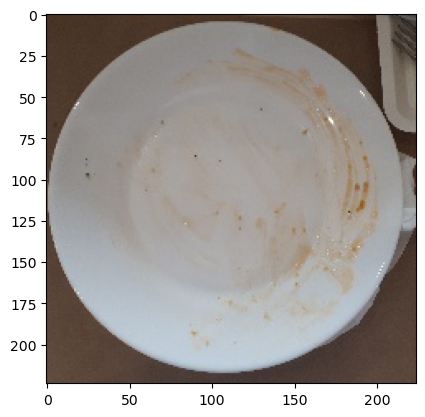

In [38]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

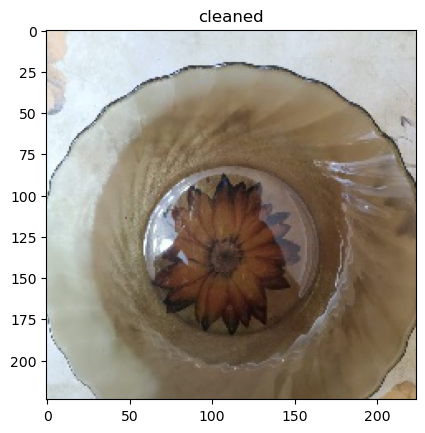

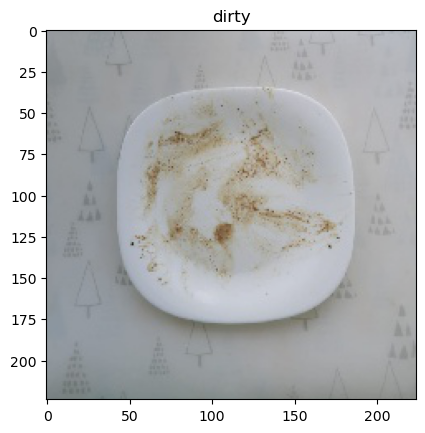

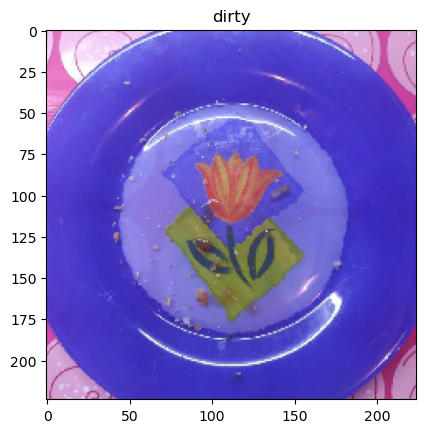

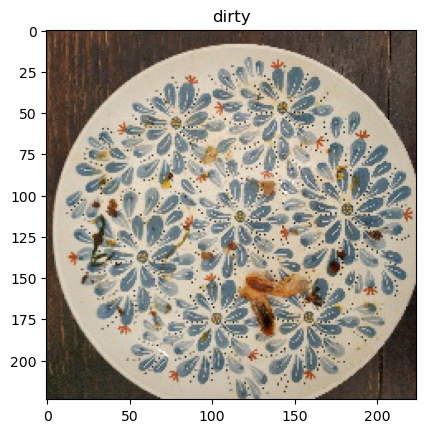

In [39]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [40]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('\033[1;31;40m Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [41]:
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
    
# M_PATH = "lab_5_models_meta/2024-03-11 19:10:47.357940"
# model = torch.load() 

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1.0e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3)

In [26]:
torch.cuda.is_available()

False

In [42]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

 Epoch 0/99:


/home/nikita/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]

train Loss: 0.6833 Acc: 0.5278



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]

val Loss: 0.7138 Acc: 0.3750
 Epoch 1/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s]

train Loss: 0.7149 Acc: 0.5000



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]

val Loss: 0.5239 Acc: 0.6250
 Epoch 2/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s]

train Loss: 0.6939 Acc: 0.5278



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]

val Loss: 0.5184 Acc: 0.6250
 Epoch 3/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.03it/s]

train Loss: 0.7118 Acc: 0.4444



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.31it/s]

val Loss: 0.5182 Acc: 0.7500
 Epoch 4/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]

train Loss: 0.6946 Acc: 0.5556



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.21it/s]

val Loss: 0.5217 Acc: 0.6250
 Epoch 5/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.7062 Acc: 0.5556



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]

val Loss: 0.4937 Acc: 0.5000
 Epoch 6/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]

train Loss: 0.6882 Acc: 0.4722



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

val Loss: 0.5123 Acc: 0.6250
 Epoch 7/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.03it/s]

train Loss: 0.7100 Acc: 0.5000



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.19it/s]

val Loss: 0.5056 Acc: 0.8750
 Epoch 8/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.04it/s]

train Loss: 0.7133 Acc: 0.4167



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]

val Loss: 0.5366 Acc: 0.5000
 Epoch 9/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.04it/s]

train Loss: 0.6964 Acc: 0.4722



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]

val Loss: 0.5367 Acc: 0.3750
 Epoch 10/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.7139 Acc: 0.4167



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.23it/s]

val Loss: 0.5207 Acc: 0.7500
 Epoch 11/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6857 Acc: 0.5278



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.26it/s]

val Loss: 0.4817 Acc: 0.8750
 Epoch 12/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6839 Acc: 0.4444



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.31it/s]

val Loss: 0.4675 Acc: 0.8750
 Epoch 13/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.05it/s]

train Loss: 0.7017 Acc: 0.4444



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

val Loss: 0.4942 Acc: 0.6250
 Epoch 14/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.03it/s]

train Loss: 0.7087 Acc: 0.4722



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

val Loss: 0.5095 Acc: 0.8750
 Epoch 15/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]

train Loss: 0.6982 Acc: 0.5278



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]

val Loss: 0.4901 Acc: 0.8750
 Epoch 16/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.04it/s]

train Loss: 0.6785 Acc: 0.6111



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

val Loss: 0.5176 Acc: 0.3750
 Epoch 17/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6810 Acc: 0.6111



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

val Loss: 0.5190 Acc: 0.6250
 Epoch 18/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]

train Loss: 0.7148 Acc: 0.4444



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]

val Loss: 0.5320 Acc: 0.3750
 Epoch 19/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6793 Acc: 0.5556



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]

val Loss: 0.5139 Acc: 0.5000
 Epoch 20/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6892 Acc: 0.5278



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]

val Loss: 0.5269 Acc: 0.6250
 Epoch 21/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6862 Acc: 0.6389



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.26it/s]

val Loss: 0.5245 Acc: 0.6250
 Epoch 22/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.7133 Acc: 0.5556



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.32it/s]

val Loss: 0.5283 Acc: 0.3750
 Epoch 23/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.7000 Acc: 0.5278



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]

val Loss: 0.5243 Acc: 0.3750
 Epoch 24/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.06it/s]

train Loss: 0.6795 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.22it/s]

val Loss: 0.5245 Acc: 0.6250
 Epoch 25/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6953 Acc: 0.5000



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

val Loss: 0.5318 Acc: 0.3750
 Epoch 26/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.04it/s]

train Loss: 0.6844 Acc: 0.5833



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]

val Loss: 0.5230 Acc: 0.3750
 Epoch 27/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6993 Acc: 0.4444



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]

val Loss: 0.5491 Acc: 0.6250
 Epoch 28/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.06it/s]

train Loss: 0.6635 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.21it/s]

val Loss: 0.5090 Acc: 0.7500
 Epoch 29/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6940 Acc: 0.4444



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]

val Loss: 0.4925 Acc: 0.5000
 Epoch 30/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6994 Acc: 0.5833



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

val Loss: 0.4595 Acc: 0.7500
 Epoch 31/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6781 Acc: 0.6111



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]

val Loss: 0.5205 Acc: 0.5000
 Epoch 32/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6819 Acc: 0.5278



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.17it/s]

val Loss: 0.5318 Acc: 0.7500
 Epoch 33/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6793 Acc: 0.4722



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

val Loss: 0.5099 Acc: 0.6250
 Epoch 34/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6885 Acc: 0.5833



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.31it/s]

val Loss: 0.4964 Acc: 0.5000
 Epoch 35/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6719 Acc: 0.5556



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

val Loss: 0.5137 Acc: 0.7500
 Epoch 36/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]

train Loss: 0.6775 Acc: 0.5833



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.20it/s]

val Loss: 0.5111 Acc: 0.7500
 Epoch 37/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]

train Loss: 0.6884 Acc: 0.5278



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

val Loss: 0.5143 Acc: 0.5000
 Epoch 38/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]

train Loss: 0.6733 Acc: 0.6111



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]

val Loss: 0.4880 Acc: 0.8750
 Epoch 39/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6833 Acc: 0.4722



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]

val Loss: 0.5136 Acc: 0.6250
 Epoch 40/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6906 Acc: 0.4722



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.32it/s]

val Loss: 0.5177 Acc: 0.7500
 Epoch 41/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6850 Acc: 0.5000



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

val Loss: 0.4963 Acc: 0.6250
 Epoch 42/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6752 Acc: 0.6111



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.24it/s]

val Loss: 0.5012 Acc: 0.6250
 Epoch 43/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6778 Acc: 0.5556



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

val Loss: 0.5159 Acc: 0.6250
 Epoch 44/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6790 Acc: 0.5556



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]

val Loss: 0.5100 Acc: 0.8750
 Epoch 45/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6712 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]

val Loss: 0.5328 Acc: 0.3750
 Epoch 46/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6696 Acc: 0.6111



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

val Loss: 0.5187 Acc: 0.5000
 Epoch 47/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6753 Acc: 0.5556



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.26it/s]

val Loss: 0.5024 Acc: 0.6250
 Epoch 48/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6704 Acc: 0.5278



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.24it/s]

val Loss: 0.5038 Acc: 0.8750
 Epoch 49/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6821 Acc: 0.6111



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

val Loss: 0.5339 Acc: 0.5000
 Epoch 50/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6757 Acc: 0.5556



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

val Loss: 0.5283 Acc: 0.5000
 Epoch 51/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6791 Acc: 0.5833



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

val Loss: 0.5069 Acc: 0.6250
 Epoch 52/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6928 Acc: 0.5833



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]

val Loss: 0.5097 Acc: 0.5000
 Epoch 53/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6693 Acc: 0.6389



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.31it/s]

val Loss: 0.5012 Acc: 0.6250
 Epoch 54/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.08it/s]

train Loss: 0.6818 Acc: 0.5278



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

val Loss: 0.5424 Acc: 0.5000
 Epoch 55/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]

train Loss: 0.6558 Acc: 0.6389



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]

val Loss: 0.5296 Acc: 0.5000
 Epoch 56/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.06it/s]

train Loss: 0.6726 Acc: 0.6389



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.26it/s]

val Loss: 0.5297 Acc: 0.6250
 Epoch 57/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.04it/s]

train Loss: 0.6655 Acc: 0.6389



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.22it/s]

val Loss: 0.5274 Acc: 0.5000
 Epoch 58/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]

train Loss: 0.6639 Acc: 0.6389



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.14it/s]

val Loss: 0.5204 Acc: 0.5000
 Epoch 59/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]

train Loss: 0.6663 Acc: 0.6111



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]

val Loss: 0.6071 Acc: 0.6250
 Epoch 60/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.00it/s]

train Loss: 0.6696 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

val Loss: 0.5281 Acc: 0.5000
 Epoch 61/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]

train Loss: 0.6729 Acc: 0.6389



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.26it/s]

val Loss: 0.5189 Acc: 0.7500
 Epoch 62/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6442 Acc: 0.8611



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.24it/s]

val Loss: 0.4900 Acc: 0.8750
 Epoch 63/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]

train Loss: 0.6631 Acc: 0.6389



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.17it/s]

val Loss: 0.5143 Acc: 0.6250
 Epoch 64/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]

train Loss: 0.6740 Acc: 0.5833



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

val Loss: 0.5032 Acc: 0.6250
 Epoch 65/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.01it/s]

train Loss: 0.6793 Acc: 0.5278



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.37it/s]

val Loss: 0.5199 Acc: 0.7500
 Epoch 66/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.10it/s]

train Loss: 0.6816 Acc: 0.5556



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.41it/s]

val Loss: 0.5265 Acc: 0.5000
 Epoch 67/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]

train Loss: 0.6649 Acc: 0.6111



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]

val Loss: 0.5377 Acc: 0.5000
 Epoch 68/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]

train Loss: 0.6656 Acc: 0.6667



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.32it/s]

val Loss: 0.5301 Acc: 0.6250
 Epoch 69/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]

train Loss: 0.6828 Acc: 0.6111



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.37it/s]

val Loss: 0.5305 Acc: 0.6250
 Epoch 70/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]

train Loss: 0.6857 Acc: 0.5278



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.41it/s]

val Loss: 0.5268 Acc: 0.6250
 Epoch 71/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]

train Loss: 0.6488 Acc: 0.7778



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]

val Loss: 0.5266 Acc: 0.5000
 Epoch 72/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]

train Loss: 0.6636 Acc: 0.7778



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.14it/s]

val Loss: 0.5154 Acc: 0.6250
 Epoch 73/99:



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.01it/s]

train Loss: 0.6671 Acc: 0.5556



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

val Loss: 0.5281 Acc: 0.5000
 Epoch 74/99:



 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:05<00:04,  1.12s/it]


KeyboardInterrupt: 

In [43]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [44]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [45]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [46]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|████████████████████████████████████████████████████████████████████████████████| 186/186 [04:08<00:00,  1.34s/it]


In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

# for img, pred in zip(inputs, test_predictions):
#     show_input(img, title=pred)

In [47]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.45 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

submission_df.to_csv('submission.csv')

In [ ]:
from datetime import datetime 
PATH = f"lab_5_models_meta/{str(datetime.now())}"
torch.save(model, PATH)

In [13]:
!rm -rf train val test